In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from util import get_labels, read_img, one_hot
import seaborn as sn
from keras.applications import inception_v3

C:\Users\denha\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Loading labels to inspect classes

In [2]:
labels = get_labels()
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


`labels` is a pandas dataframe with two columns: `id` and `breed`. `id` is the unique identifier for an image (the images in the data folder are named as `<id>.jpg`), and `breed` is the corresponding label.

Let's look at the class distribution:

In [3]:
labels['breed'].value_counts()

scottish_deerhound                126
maltese_dog                       117
afghan_hound                      116
entlebucher                       115
bernese_mountain_dog              114
shih-tzu                          112
great_pyrenees                    111
pomeranian                        111
basenji                           110
samoyed                           109
airedale                          107
tibetan_terrier                   107
cairn                             106
leonberg                          106
beagle                            105
japanese_spaniel                  105
australian_terrier                102
miniature_pinscher                102
blenheim_spaniel                  102
irish_wolfhound                   101
saluki                             99
lakeland_terrier                   99
papillon                           96
siberian_husky                     95
whippet                            95
norwegian_elkhound                 95
pug         

So we have 120 different breeds, with the most common breed being the _scottish dearhound_ and the least common breed the _eskimo dog_ (I have not even heard of that one ever...).

### Let's look at some doggos

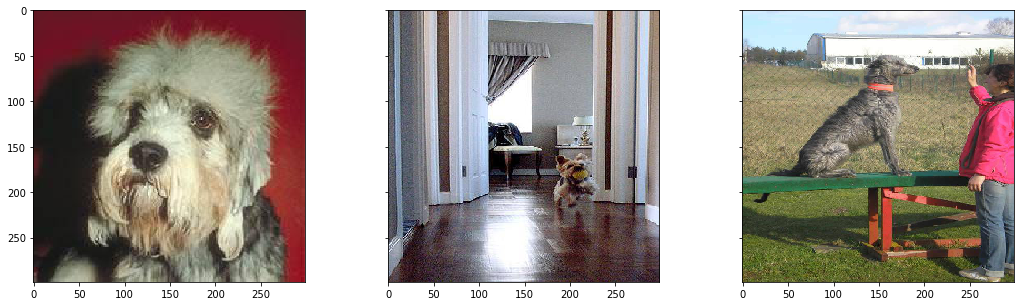

In [4]:
random_doggos = np.random.choice(labels['id'], 3)
imgs = [read_img(doggo, 'train', 299) for doggo in random_doggos]

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[18,5], sharey=True)
ax1.imshow(imgs[0]/255)
ax2.imshow(imgs[1]/255)
ax3.imshow(imgs[2]/255)

# FUCKIN' SWEET

In [5]:
base_model = inception_v3.InceptionV3(weights='imagenet', include_top=False)

print('Layers of the Inception V3 model:')
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

Layers of the Inception V3 model:
0 input_1
1 conv2d_1
2 batch_normalization_1
3 activation_1
4 conv2d_2
5 batch_normalization_2
6 activation_2
7 conv2d_3
8 batch_normalization_3
9 activation_3
10 max_pooling2d_1
11 conv2d_4
12 batch_normalization_4
13 activation_4
14 conv2d_5
15 batch_normalization_5
16 activation_5
17 max_pooling2d_2
18 conv2d_9
19 batch_normalization_9
20 activation_9
21 conv2d_7
22 conv2d_10
23 batch_normalization_7
24 batch_normalization_10
25 activation_7
26 activation_10
27 average_pooling2d_1
28 conv2d_6
29 conv2d_8
30 conv2d_11
31 conv2d_12
32 batch_normalization_6
33 batch_normalization_8
34 batch_normalization_11
35 batch_normalization_12
36 activation_6
37 activation_8
38 activation_11
39 activation_12
40 mixed0
41 conv2d_16
42 batch_normalization_16
43 activation_16
44 conv2d_14
45 conv2d_17
46 batch_normalization_14
47 batch_normalization_17
48 activation_14
49 activation_17
50 average_pooling2d_2
51 conv2d_13
52 conv2d_15
53 conv2d_18
54 conv2d_19
55 bat

Wow, that's a lot of layers. The network is organized in "Inception blocks" which are multiple convolutional neural networks of different depths which work in parallel (https://arxiv.org/abs/1512.00567). The second last inception layer starts at layer 249 and last one starts at layer 280. To fine-tune the network we will need to freeze everything except the top X layers.
![Image of Inception Block](https://ashstuff.github.io/img/Capture111.PNG)

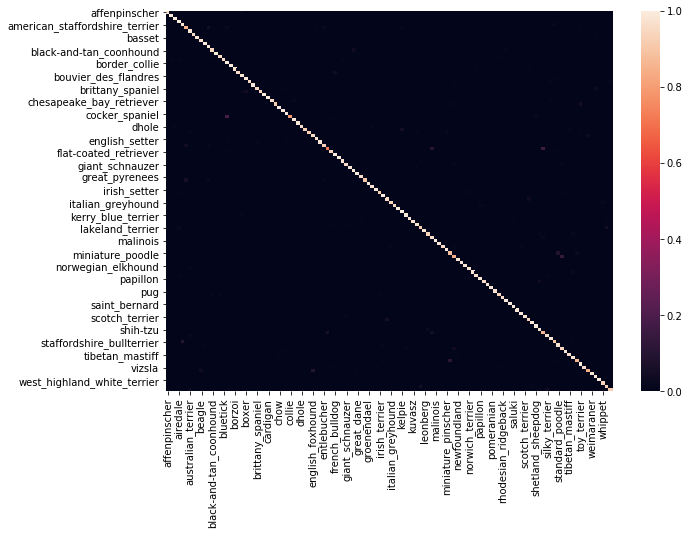

In [6]:
labels = get_labels().sort_values(by=['breed']).breed.unique()
conf_arr = np.genfromtxt('conf_mat1.csv', delimiter=',')
conf_arr = conf_arr / conf_arr.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(conf_arr, index = labels, columns = labels)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm)

Overall good performance but there are some classes that get confused with eachother. Next step is looking at these cases.

In [7]:
correct = np.diagonal(conf_arr)
print(labels[np.where(correct<0.8)])

['collie' 'eskimo_dog']


In [8]:
ids = np.where(correct<0.96)
print(labels[ids])
conf_arr = conf_arr[ids, :].squeeze()
conf_arr = conf_arr[:, ids].squeeze()

['appenzeller' 'black-and-tan_coonhound' 'boston_bull' 'brabancon_griffon'
 'brittany_spaniel' 'bull_mastiff' 'chihuahua' 'collie' 'dingo' 'doberman'
 'english_foxhound' 'entlebucher' 'eskimo_dog' 'flat-coated_retriever'
 'giant_schnauzer' 'greater_swiss_mountain_dog' 'irish_terrier'
 'italian_greyhound' 'japanese_spaniel' 'lakeland_terrier' 'lhasa'
 'miniature_poodle' 'miniature_schnauzer' 'redbone' 'rhodesian_ridgeback'
 'scottish_deerhound' 'siberian_husky' 'staffordshire_bullterrier'
 'standard_schnauzer' 'toy_poodle' 'vizsla' 'walker_hound' 'whippet'
 'wire-haired_fox_terrier' 'yorkshire_terrier']


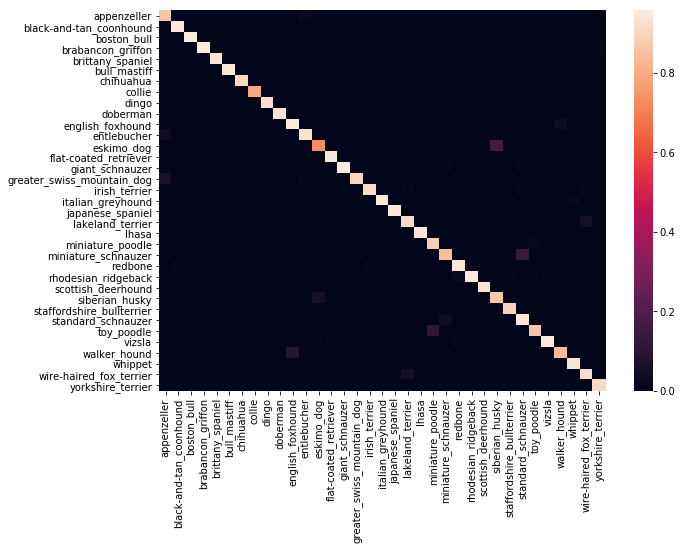

In [9]:
df_cm = pd.DataFrame(conf_arr, index = labels[ids], columns = labels[ids])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm)

In [14]:
pred_labels = np.genfromtxt('pred_val1.csv', delimiter=',')
pred_labels.shape

(10222, 120)

In [15]:
true_labels = y_train = one_hot(get_labels()['breed'].values)
true_labels.shape

(10222, 120)

In [19]:
true_labels = np.argmax(true_labels, axis=1)
pred_labels = np.argmax(pred_labels, axis=1)

In [21]:
pred_labels.shape

(10222,)

In [23]:
np.argmin(correct)

43

'eskimo_dog'